In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-08-01 14:41


# Agreement between sequence and structure performance

We will compare the annotation produced by AlphaFold+FoldSeek against that produced by EggNOG-mapper. If our idea worked well, we should see that in the overwhelming majority of cases the structural pipeline identifies the same annotation for each _Spongilla_ protein.

In [2]:
import glob
from os.path import exists

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Read the two tables:

In [3]:
structural_annotation = pd.read_parquet('../data/structure_annotation.parquet')
sequence_annotation = pd.read_csv('../data/Slacustris_eggnog.tsv', sep='\t')

Identify the bit score cut off and threshold the structure annotation:

In [4]:
keep = np.intersect1d(sequence_annotation['protein_id'], structural_annotation['protein_id'])
# bitscore_cut_off = structural_annotation.set_index('protein_id').loc[keep]['bit score'].min()
bitscore_cut_off = np.exp(5)

keep = structural_annotation['bit score'] >= bitscore_cut_off
structural_annotation = structural_annotation[keep].copy()
structural_annotation.shape, sequence_annotation.shape

((25232, 30), (17990, 11))

## EggNOG most specific OrthoGroup level

this is the ideal scenario: for how many cases do the two annotation pipelines put a gene in the same group of orthologous genes? Extract the EggNOG OG information and compare. Look both directions; if the most specific sequence orthogroup is in the structure OGs or if the most specific structure OG is in the sequence OGs.

In [5]:
orthogroups_prot = sequence_annotation[['protein_id', 'eggNOG_OGs']].merge(structural_annotation[['protein_id', 'eggNOG_OGs']], 
                                                                           on='protein_id', suffixes=['_seq', '_struct'])

In [6]:
orthogroups_prot.shape

(16589, 3)

We lose ~1400 peptides - our cut-off might have been too strict. We'd like to be sure about our conclusions though, so let's keep going like this. Isolate the most specific orthogroup for each peptide.

In [7]:
def keep_last(row):
    """
    A function to isolate the root EggNOG orthogroup.
    
    Expects a comma-separated string where the root orthogroup
    contains the word 'root'.
    """
    x = np.array(row.split(','))
    return x[-1]

In [8]:
orthogroups_prot['most_specific_struct'] = orthogroups_prot['eggNOG_OGs_struct'].apply(keep_last)
orthogroups_prot['most_specific_seq'] = orthogroups_prot['eggNOG_OGs_seq'].apply(keep_last)

Compare the root orthogroup lists of each gene between tables. Hitting at least one is considered a success.

In [9]:
def contains_OG(row):
    seq_contains_struct = row['most_specific_struct'] in row['eggNOG_OGs_seq']
    struct_contains_seq = row['most_specific_seq'] in row['eggNOG_OGs_struct']
    return seq_contains_struct | struct_contains_seq

In [10]:
orthogroups_prot['most_specific_OG'] = orthogroups_prot.apply(contains_OG, axis=1)

In [11]:
specific_overlap = np.sum(orthogroups_prot['most_specific_OG'])
total = len(orthogroups_prot)
print(f'A total of {specific_overlap} out of {total} annotated peptides overlap \
in the most specific OG ({specific_overlap / total * 100:.2f}%).')

A total of 9402 out of 16589 annotated peptides overlap in the most specific OG (56.68%).


## EggNOG root OrthoGroup level

this is the most pertinent level: for how many cases do the two annotation pipelines put a gene in the same group of orthologous genes? Extract the EggNOG OG information and compare. To facilitate the comparison we will only look at the root level, but we could extend this as much as we want (e.g. pick the most specific orthogroup for structure and ask if it is found in the sequence annotation).

Isolate the root orthogroup for each peptide. If multiple root orthogroups are present, keep all of them.

In [12]:
def keep_root(row):
    """
    A function to isolate the root EggNOG orthogroup.
    
    Expects a comma-separated string where the root orthogroup
    contains the word 'root'.
    """
    x = np.array(row.split(','))
    keep = np.zeros(len(x), dtype=bool)
    for i, og in enumerate(x):
        keep[i] = 'root' in og
#     print(x, keep)
    return x[keep]

In [13]:
orthogroups_prot['eggNOG_OGs_struct'] = orthogroups_prot['eggNOG_OGs_struct'].apply(keep_root)
orthogroups_prot['eggNOG_OGs_seq'] = orthogroups_prot['eggNOG_OGs_seq'].apply(keep_root)

Compare the root orthogroup lists of each gene between tables. Hitting at least one is considered a success.

In [14]:
def is_contained_in(row, x='eggNOG_OGs_struct', y='eggNOG_OGs_seq'):
    overlap = np.intersect1d(row[x], row[y])
    return len(overlap) > 0

In [15]:
orthogroups_prot['root_OG_agree'] = orthogroups_prot.apply(is_contained_in, axis=1)

In [16]:
og_overlap = np.sum(orthogroups_prot['root_OG_agree'])
total = len(orthogroups_prot)
print(f'A total of {og_overlap} out of {total} annotated peptides have \
the same structure and sequence root ortholog ({og_overlap / total * 100:.2f}%).')

A total of 15024 out of 16589 annotated peptides have the same structure and sequence root ortholog (90.57%).


## PFAM domain overlap

Sometimes EggNOG classifies very similar proteins in different orthogroups. A way to rescue some proteins from this is to compare the distribution of PFAM domains.

Extract the peptides with disagreeing OGs:

In [17]:
unannotated_proteins = orthogroups_prot['protein_id'][~orthogroups_prot['root_OG_agree']]
seq_unannanotated = sequence_annotation.set_index('protein_id').loc[unannotated_proteins]
struct_unannanotated = structural_annotation.set_index('protein_id').loc[unannotated_proteins]

Merge the unannotated peptides into one table and again convert the comma-separated PFAM domains into lists of domains:

In [18]:
keep = ['Preferred_name', 'Description', 'PFAMs']
unannotated = seq_unannanotated[keep].join(struct_unannanotated[keep], lsuffix='_seq', rsuffix='_struct')
unannotated = unannotated.replace('-', np.NaN)

unannotated['PFAMs_struct'] = unannotated['PFAMs_struct'].str.split(',')
unannotated['PFAMs_seq'] = unannotated['PFAMs_seq'].str.split(',')

In [19]:
def term_overlap(row, x='PFAMs_struct', y='PFAMs_seq'):
    """
    Count how many strings overlap between two list-shaped DataFrame
    columns. If one of the columns does not contain a list the overlap
    is considered to be zero.
    """
    if type(row[x]) is not list or type(row[y]) is not list:
        return 0
    overlap = np.intersect1d(row[x], row[y])
    return len(overlap)

Find overlap and convert it to percentage of sequence domains present in the structure annotation:

In [20]:
length = unannotated['PFAMs_seq'].apply(lambda x: 1 if type(x) is not list else len(x))
unannotated['%overlap'] = unannotated.apply(lambda row: term_overlap(row), axis=1) / length

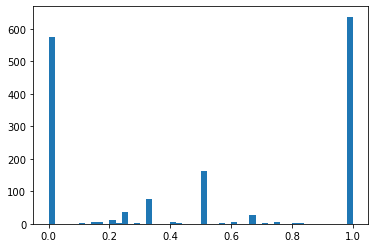

In [21]:
fig, ax = plt.subplots()
ax.hist(unannotated['%overlap'], bins=50);

A nicely bimodal distribution. We will cut off at 50%, since this will catch proteins with two domains where one overlaps.

In [22]:
pfam_overlap = np.sum(unannotated['%overlap'] >= 0.5)
total = len(unannotated)
print(f'A total of {pfam_overlap} out of {total} peptides with EggNOG orthogroup disagreement share \
at least 50% of their PFAM domains ({pfam_overlap / total * 100:.2f}%).')

A total of 845 out of 1565 peptides with EggNOG orthogroup disagreement share at least 50% of their PFAM domains (53.99%).


Let's make a table to hold that information:

Since we're doing this we might as well check how many get the exact same preferred name, as another level of validation. This is going to be very inexact, since many proteins have different names, but hopefully since CoFFE also went through EggNOG this works well enough:

In [23]:
names = sequence_annotation[['protein_id', 'Preferred_name']].merge(structural_annotation[['protein_id', 'Preferred_name']], 
                                                                    on='protein_id', suffixes=['_seq', '_struct'])

In [24]:
named_same = names['Preferred_name_seq'].str.lower() == names['Preferred_name_struct'].str.lower()
named = orthogroups_prot['protein_id'][named_same]

In [25]:
def split_by_membership(query, target):
    query_in_target = np.intersect1d(query, target)
    query_not_target = np.setdiff1d(query, target)
    return query_in_target, query_not_target

In [26]:
keep = orthogroups_prot['most_specific_OG']
specific_og = orthogroups_prot[keep]['protein_id'].values
same_name_spec, diff_name_spec = split_by_membership(specific_og, named)

keep = orthogroups_prot['root_OG_agree'] & ~orthogroups_prot['most_specific_OG']
root_og = orthogroups_prot[keep]['protein_id'].values
same_name_root, diff_name_root = split_by_membership(root_og, named)

keep = unannotated['%overlap'] >= 0.5
by_pfam = unannotated[keep].index.values
same_name_pfam, diff_name_pfam = split_by_membership(by_pfam, named)

In [27]:
len(same_name_spec), len(same_name_root), len(same_name_pfam)

(7059, 2958, 290)

In [28]:
(len(same_name_spec) + len(same_name_root) + len(same_name_pfam)) / np.sum(named_same)

0.9775227617602428

wow

In [29]:
annotated = np.concatenate((same_name_spec, diff_name_spec,
                            same_name_root, diff_name_root,
                            same_name_pfam, diff_name_pfam))
not_annotated = np.setdiff1d(orthogroups_prot['protein_id'], annotated)
prt_id = np.concatenate((annotated, not_annotated))
source = ['Specific OG\nsame name'] * len(same_name_spec) + \
        ['Specific OG'] * len(diff_name_spec) + \
        ['Root OG\nsame name'] * len(same_name_root) + \
        ['Root OG'] * len(diff_name_root) + \
        ['50% PFAM\nsame name'] * len(same_name_pfam) + \
        ['50% PFAM'] * len(diff_name_pfam) + \
        ['no agreement'] * len(not_annotated)

annotation_status = pd.DataFrame({'protein_id': prt_id, 'annotation status': source})

In [30]:
annotation_status.to_csv('../data/annotation_status.tsv', sep='\t', index=False)

In [31]:
total_overlap = len(annotated)
total = len(orthogroups_prot)
print(f'A total of {total_overlap} out of {total} annotated peptides agree \
in annotation between sequence and structure ({total_overlap / total * 100:.2f}%).')

A total of 15870 out of 16589 annotated peptides agree in annotation between sequence and structure (95.67%).
